In [1]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/pufr_fixed_jetME/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_origin_sig = f["jet_origin"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("ntuples/pufr_fixed_jetME/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_origin_bkg = f["jet_origin"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

FileNotFoundError: [Errno 2] No such file or directory: '/home/luke/Pileup_Project/analysis/ntuples/pufr_fixed_jetME/dataset_mu60_ztt1000_10k.root'

In [3]:
class Jet:
    """
    The Jet object contains the features of each jet at the event level.
    It also has many useful methods to assist with data processing.
    """
    def __init__(self, feats):
        pt, eta, phi, m, pufr, label, origin = feats
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.m = m
        self.pufr = pufr
        self.label = label
        self.origin = origin

In [4]:
# Construct list of features
feats_sig = [jet_pt_sig, jet_eta_sig, jet_phi_sig, jet_m_sig, jet_pufr_sig, jet_label_sig, jet_origin_sig]
feats_bkg = [jet_pt_bkg, jet_eta_bkg, jet_phi_bkg, jet_m_bkg, jet_pufr_bkg, jet_label_bkg, jet_origin_bkg]

# Combined Signal and Background
feats = []
for i in range(len(feats_sig)):
    feats.append(ak.concatenate([feats_sig[i],feats_bkg[i]], axis=0))
    
# Initialize Jet object and pass features
jets = Jet(feats)

# Print features
print(jets.pt)
print(jets.eta)
print(jets.phi)
print(jets.m)
print(jets.pufr)
print(jets.label)
print(jets.origin)

[[228, 172, 117, 98.6, 84.6, 47.1, ..., 26.7, 26.4, 25.8, 25.8, 25.5], ...]
[[-1.18, 1.31, 0.943, -1.1, 0.682, ..., -2.4, 3.03, -3.3, 1.94, 1.83], ...]
[[2.05, 4.71, 5.34, 1.46, 6.11, 3.81, ..., 2.23, 1.86, 4.27, 5.31, 0.443], ...]
[[50.4, 35.5, 31.4, 27.7, 22.9, 27.7, ..., 14.6, 14.4, 10.3, 14.7, 14.4], ...]
[[0.0379, 0.00049, 0.0966, 0.00467, 0.0275, ..., 0.345, 1, 0.949, 1], ...]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ...]
[[24, -24, -24, 24, 6, -1, -1, 6, -1, ..., 6, 6, -1, -1, -1, -1, -1, -1], ...]


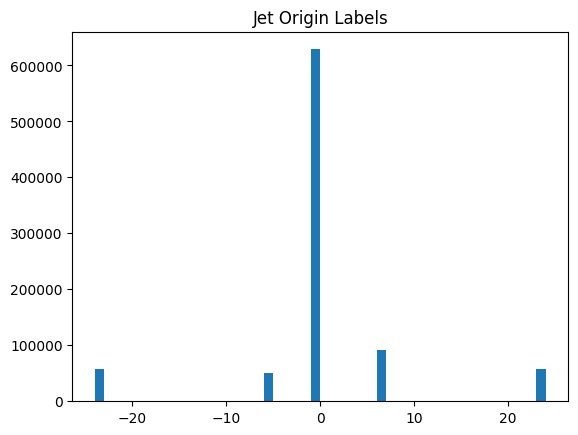

In [5]:
# Plot Origin Labels
plt.hist(ak.flatten(jets.origin), bins=48)
plt.title("Jet Origin Labels")
plt.show()

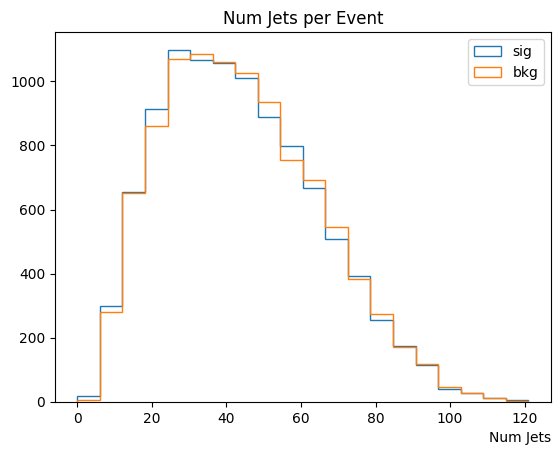

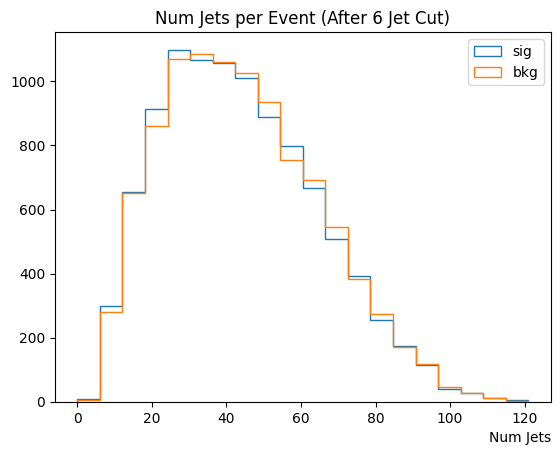

In [7]:
# Plot number of jets per event
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

# Require at least six jets
mask = h_num_jets>=6
jets.apply_mask(mask)
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
plt.title('Num Jets per Event (After 6 Jet Cut)')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,ak.max(h_num_jets)))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,ak.max(h_num_jets)))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

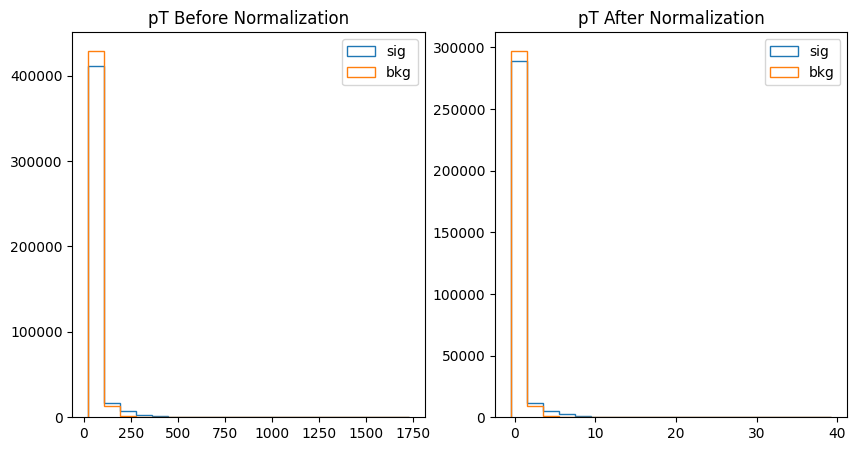

Before Mean:  44.96555102556809
Before STD:  42.64007263490457
After Mean:  -0.00023529166798927053
After STD:  1.000182010262095


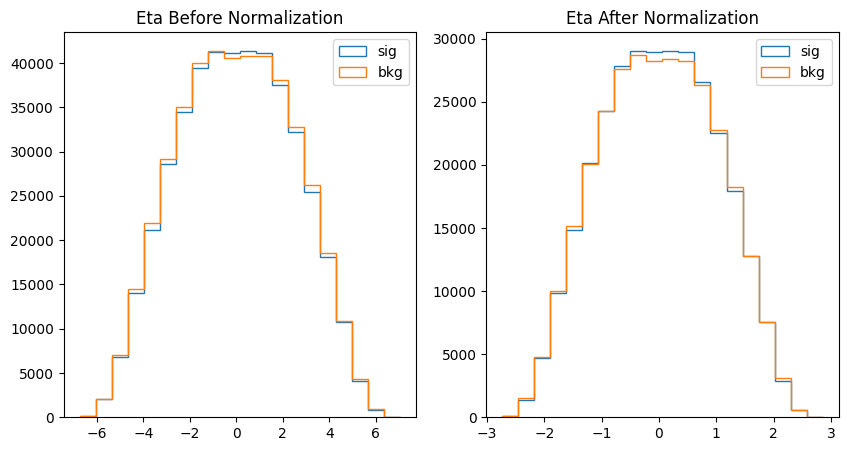

Before Mean:  -0.001279100112561276
Before STD:  2.466722873302103
After Mean:  5.1029496139628616e-08
After STD:  1.0000843238048982


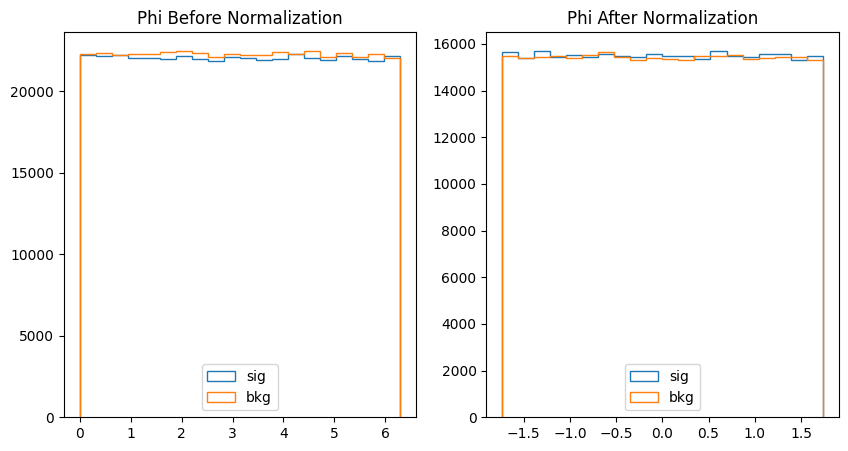

Before Mean:  3.138396384437913
Before STD:  1.812719609809242
After Mean:  2.8251374823418e-05
After STD:  1.0002596209361359


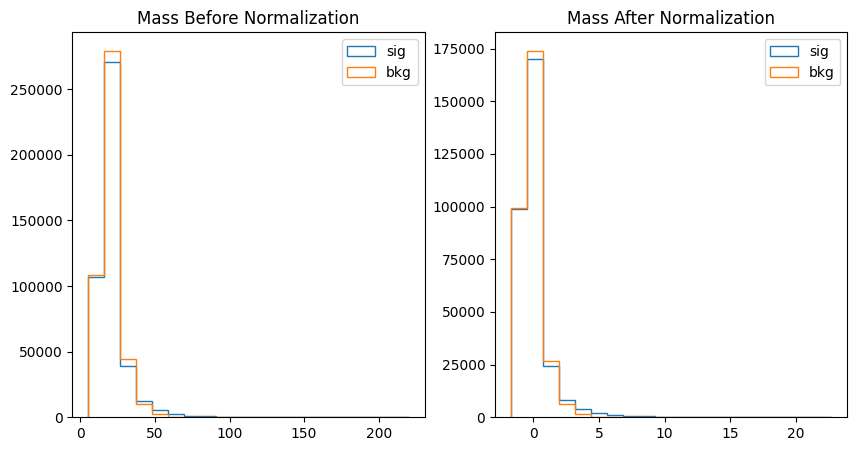

Before Mean:  20.958810223624862
Before STD:  8.732734559437127
After Mean:  -3.356611804763685e-06
After STD:  1.0000618967287622


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [9]:
# Validation plots
var_list = ['pT','Eta','Phi','Mass']
var_list_before = [jets.pt,jets.eta,jets.phi,jets.m]
var_list_after = [X_train[:,:,0],X_train[:,:,1],X_train[:,:,2],X_train[:,:,3]]

for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = var_list_before[i]
    mini=ak.min(var1)
    maxi=ak.max(var1)
    sig,bkg = jets.return_event_idx()
    ax1.hist(ak.ravel(var1[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax1.hist(ak.ravel(var1[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = var_list_after[i]
    mini=ak.min(var2)
    maxi=ak.max(var2)
    sig = (y_train[0]==1)
    bkg = ~sig
    ax2.hist(ak.ravel(var2[sig]),histtype='step',label='sig',bins=20,range=(mini,maxi))
    ax2.hist(ak.ravel(var2[bkg]),histtype='step',label='bkg',bins=20,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.nested.nested_tensor(ak.to_list(X_train))
label_train = torch.Tensor(y_train[0]).reshape(-1,1)
origin_train = torch.nested.nested_tensor(ak.to_list(y_train[1]))

X_val = torch.nested.nested_tensor(ak.to_list(X_val))
label_val = torch.Tensor(y_val[0]).reshape(-1,1)
origin_val = torch.nested.nested_tensor(ak.to_list(y_val[1]))

X_test = torch.nested.nested_tensor(ak.to_list(X_test))
label_test = torch.Tensor(y_test[0]).reshape(-1,1)
origin_test = torch.nested.nested_tensor(ak.to_list(y_test[1]))